In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
import time
import copy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import random_split

# **Convolutional Neural Networks**

We've seen until now the perceptron and the Multilayer Perceptron concepts. Both receive the entire entry in their inputs and learn to map it into another representation - often in reduced dimensionality. However, regarding images, Neural Networks used to be much larger in size, thereby enlarging convergence time, requiring dimensional reductional of the input, e. g. PCA, losing information that should be important.
CNN comes with three main ideas. **First**, constraining the application domain to image domain and exploring some spatial correlation in the image (in MLP we needed to rectify the image to forward it in the model, so we lost the spatial information). **Second**, embedding knowledge into it: kernel operations in digital image processing are vastly used to feature extraction (see Fig 1). So why shouldn't deep learning models take advantage of them? **Third**, and finally, degrees of freedom reduction, thus reducing the size of the network. It is called weight sharing: the neuron no more receives the entire entry, but it sees a neighborhood of NXN inputs and slips over along the image, sharing its weights with the other inputs.

![filtering](https://miro.medium.com/max/2540/1*3hDhkzqJStXTp37lS_M5aA.png)

<center>Fig 1. What is image filtering for feature extraction</center>

# **Why convolutional?**

---

convolution in images is the process of applying a known kernel into the prior representation of an image and the result of this operation is a posterior representation of it. We can see below a better explantion if gif format.

![conv 1](https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Convolution_Animation.gif)

# **CNN modules**
<br>There is some components frequently used in building models: convolutional (as we saw) and pooling (dummy dimensional reduction).
Pooling is a dimensional reduction non-learned by the model. Usually, the pooling layer is a max function over the NxN neighborhood, but there are many types of pooling, e. g. average pool, adaptive average pool, etc.

![pooling](https://qph.fs.quoracdn.net/main-qimg-cf2833a40f946faf04163bc28517959c)


#**The very first CNN architecture applied to digits recognition (LeNet)**

![LeNet](https://www.researchgate.net/profile/Yiren_Zhou/publication/312170477/figure/fig1/AS:448817725218816@1484017892071/Structure-of-LeNet-5.png)



In [0]:
#@title Loading the dataset the same way as before, but now using Normalization
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

test, val = random_split(dataset_test, lengths = (5000,5000))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_loader = DataLoader(dataset=dataset_train, shuffle=True)
test_loader = DataLoader(dataset=test, shuffle=False)
val_loader = DataLoader(dataset=val, shuffle=False)

dataloaders = {'train': train_loader, 'val':val_loader, 'test' : test_loader }

dataset_sizes = {'train' : len(train_loader.dataset), 'test' : len(test_loader.dataset), 'val': len(val_loader.dataset)}

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    
    #input_channel, output_channel, feature_dimension(kernel_size), stride, padding
    self.feats = nn.Sequential(
        
        nn.Conv2d(3, 20, kernel_size = 3, stride = 1, bias =False), #30x30x20
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),#15x15x20
        nn.ReLU(True),
        nn.BatchNorm2d(20),
        
        
        nn.Conv2d(20, 256, kernel_size = 3, stride = 1, padding = 1, bias=False), #15x15x256
        nn.MaxPool2d(kernel_size = 3, stride = 2),#7x7x256
        nn.ReLU(True),
        nn.BatchNorm2d(256),
        
      
        nn.MaxPool2d(kernel_size = 3, stride = 2 )#3x3x256
    )
    self.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(3*3*256,768),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(768, 10),
        nn.LogSoftmax(1)
    )
  def forward(self,x):
    x = self.feats(x) # CNN
    x = x.view(-1,3*3*256) # Lineariza 
    x = self.fc(x) #Classifica
    return x

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [0]:
from sklearn import metrics as mtr
#import pandas_ml

def evaluate(model, data_loader):
  acc = 0.0
  model.eval()
  y_hat = []
  y_true = []
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_hat.append(preds)
        acc += torch.sum(preds == labels.data)

  
  print('Acc test_set: {:.4f}'.format(acc.double()/len(data_loader.dataset)))
  Y_true = [y_true for inputs, labels in iter(data_loader) for y_true in labels.cpu().numpy()]
  print(Y_true)
  Y_hat =  [label for joint in y_hat for label in joint.cpu().numpy()]
  print(mtr.classification_report(Y_true, Y_hat))
  plt.rcParams["figure.figsize"] = (10,10)
  mtr.ConfusionMatrixDisplay(mtr.confusion_matrix(Y_true, Y_hat), display_labels= classes).plot()
  plt.show()



In [0]:
model_ft = CNN()

lr = 1e-4 #@param
momentum = 0.9 #@param
step_size  = 7 #@param
gamma = 0.1 #@param

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss() #@param ["torch.nn.CrossEntropyLoss()", "torch.nn.NLLLoss()", "torch.nn.MultiLabelSoftMarginLoss()"] {type:"raw"}

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

#@markdown ---
#@markdown Here we will set our model's hyper-parameters. 

In [0]:
#@title training our model
model = train_model(model_ft, criterion, optimizer_ft, scheduler, 5)

Epoch 0/4
----------
train Loss: 1.8742 Acc: 0.3232
val Loss: 2.2425 Acc: 0.2562

Epoch 1/4
----------
train Loss: 1.5871 Acc: 0.4361
val Loss: 2.4280 Acc: 0.3268

Epoch 2/4
----------
train Loss: 1.3403 Acc: 0.5316
val Loss: 2.4422 Acc: 0.3276

Epoch 3/4
----------
train Loss: 1.2822 Acc: 0.5541
val Loss: 2.2482 Acc: 0.3806

Epoch 4/4
----------
train Loss: 1.2485 Acc: 0.5641
val Loss: 2.6551 Acc: 0.3626

Training complete in 15m 48s
Best val Acc: 0.380600


Acc test_set: 0.3806
[1, 6, 6, 2, 7, 3, 8, 6, 8, 1, 3, 2, 1, 4, 9, 5, 8, 4, 2, 3, 1, 1, 5, 5, 1, 9, 7, 2, 3, 5, 2, 6, 4, 6, 3, 3, 6, 2, 8, 1, 6, 6, 3, 8, 3, 4, 4, 9, 4, 3, 0, 7, 5, 0, 1, 3, 9, 8, 2, 2, 3, 5, 5, 7, 0, 1, 4, 7, 4, 8, 3, 7, 4, 7, 3, 6, 0, 1, 8, 5, 6, 7, 8, 3, 2, 9, 7, 8, 9, 0, 7, 3, 6, 6, 0, 5, 9, 3, 2, 7, 0, 2, 4, 4, 5, 0, 6, 2, 7, 1, 3, 4, 9, 9, 0, 5, 3, 9, 9, 4, 7, 9, 8, 9, 0, 4, 1, 1, 5, 9, 2, 6, 3, 0, 5, 8, 8, 9, 5, 9, 3, 5, 6, 7, 6, 0, 1, 7, 0, 7, 9, 1, 1, 6, 5, 2, 0, 0, 1, 1, 0, 7, 1, 4, 7, 8, 7, 9, 5, 1, 5, 9, 9, 2, 8, 2, 7, 3, 9, 9, 0, 3, 5, 6, 1, 1, 5, 3, 2, 3, 4, 4, 8, 5, 9, 6, 8, 2, 6, 4, 3, 1, 6, 5, 6, 5, 8, 5, 4, 6, 2, 1, 6, 2, 6, 3, 6, 9, 0, 3, 9, 2, 4, 3, 9, 6, 2, 1, 8, 5, 5, 0, 2, 7, 1, 4, 9, 1, 7, 4, 2, 8, 8, 8, 6, 5, 8, 7, 7, 3, 5, 2, 6, 3, 2, 1, 0, 5, 2, 7, 3, 7, 6, 0, 0, 0, 7, 7, 0, 0, 1, 0, 8, 8, 7, 5, 6, 7, 2, 8, 0, 3, 0, 5, 9, 9, 1, 2, 7, 3, 5, 5, 5, 5, 5, 3, 4, 4, 7, 0, 0, 1, 8, 8, 1, 1, 4, 0, 8, 8, 2, 4, 1, 9, 6, 7, 5, 1, 0, 4, 2, 2, 7, 9, 0, 2, 

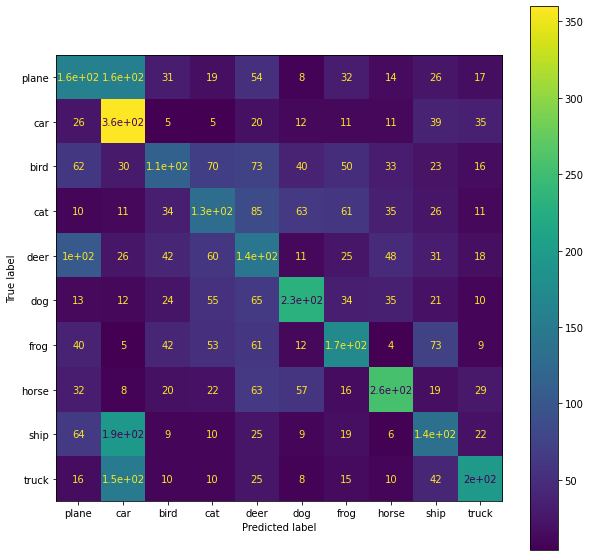

In [0]:
#@title assessment of our model

evaluate(model, dataloaders['val'])

# Training with a known architecture 

In [0]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

test, val = random_split(dataset_test, lengths = (5000,5000))

Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_loader = DataLoader(dataset=dataset_train, shuffle=True)
test_loader = DataLoader(dataset=test, shuffle=False)
val_loader = DataLoader(dataset=val, shuffle=False)

dataloaders = {'train': train_loader, 'val':val_loader, 'test' : test_loader }

dataset_sizes = {'train' : len(train_loader.dataset), 'test' : len(test_loader.dataset), 'val': len(val_loader.dataset)}

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [0]:
#@title Selecting the ResNet18 architecture [reference](https://arxiv.org/abs/1512.03385)
model_ft = models.resnet18(pretrained=False)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

lr = 1e-4 #@param
momentum = 0.9 #@param
step_size  = 7 #@param
gamma = 0.1 #@param

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss() #@param ["torch.nn.CrossEntropyLoss()", "torch.nn.NLLLoss()", "torch.nn.MultiLabelSoftMarginLoss()"] {type:"raw"}

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

#@markdown ---
#@markdown Here we will set our model's hyper-parameters. 

In [0]:
#@title Here we can see all the architectures we can clone and use as reference
dir(models)
#@markdown ---
#@markdown Change the line first code line ```model_ft = models.<archi_you_want>(Pretrained = {True,False})```
#@markdown <br>if the argument <Pretrained> is set as True, we will download the pre-trained  model with the imagenet dataset,
#@markdown so we can use transfer learning technique in order to improve model's accuracy <br>

#@markdown ---
#@markdown I suggest, if you want to explore all the models, to read the paper related to it. Depending of the model the input dimensionality is different, therefore you need to resize the input shape to pair the model's shape 


['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [0]:
model = train_model(model_ft,criterion, optimizer_ft, scheduler)

In [0]:
evaluate()

Acc test_set: 0.2788
Acc training_set: 0.2767


In [0]:
#@title Selecting the ResNet18 architecture [reference](https://arxiv.org/abs/1512.03385) and using Transfer Learning 
#@markdown ---
#@markdown In Transfer Learning we can freeze some layers (do not update them) and make a fine-tunning on the others
#@markdown <br> Here we will freeze all the convolutional layers and train only the MLP classifier
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features

############### EDIT the Classifier here ################
model_ft.fc = nn.Linear(num_ftrs, 290)
model_ft.act = nn.ReLU()
model_ft.fc2 = nn.Linear(290,10)
    
#########################################################



lr = 1e-4 #@param
momentum = 0.9 #@param
step_size  = 7 #@param
gamma = 0.1 #@param

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss() #@param ["torch.nn.CrossEntropyLoss()", "torch.nn.NLLLoss()", "torch.nn.MultiLabelSoftMarginLoss()"] {type:"raw"}

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

#@markdown ---
#@markdown Here we will set our model's hyper-parameters. 

In [0]:
model = train_model(model_ft, criterion, optimizer_ft, scheduler, 25)

In [0]:
evaluate(model, dataloaders['val'])

Acc test_set: 0.2763
Acc training_set: 0.2662


In [0]:
#@title Transfer Learning using fine-tunning
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = True #@markdown ```param.requires_grad = True```<br> setting this parameter as True we unfreeze all the layers and backwards the error - it updates all the model.
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, 290),
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(290,126),
        nn.ReLU(),
        nn.Linear(126,10),
        nn.LogSoftmax(dim = 1))

lr = 1e-4 #@param
momentum = 0.9 #@param
step_size  = 7 #@param
gamma = 0.1 #@param

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss() #@param ["torch.nn.CrossEntropyLoss()", "torch.nn.NLLLoss()", "torch.nn.MultiLabelSoftMarginLoss()"] {type:"raw"}

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

#@markdown ---
#@markdown Here we will set our model's hyper-parameters. 


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
model = train_model(model_ft, criterion, optimizer_ft, scheduler, 5)

Epoch 0/4
----------
train Loss: 2.3049 Acc: 0.1003
val Loss: 2.3007 Acc: 0.1192

Epoch 1/4
----------
train Loss: 2.3030 Acc: 0.1001
val Loss: 2.3025 Acc: 0.0930

Epoch 2/4
----------
train Loss: 2.3029 Acc: 0.0995
val Loss: 2.3012 Acc: 0.1056

Epoch 3/4
----------
train Loss: 2.3030 Acc: 0.0994
val Loss: 2.3019 Acc: 0.0950

Epoch 4/4
----------
train Loss: 2.3029 Acc: 0.0968
val Loss: 2.3017 Acc: 0.0960

Training complete in 76m 54s
Best val Acc: 0.119200


Acc test_set: 0.1192
[2, 1, 5, 6, 8, 7, 9, 6, 8, 1, 6, 3, 2, 9, 9, 5, 5, 6, 3, 4, 5, 2, 1, 0, 1, 1, 4, 5, 5, 7, 8, 3, 8, 8, 4, 4, 1, 6, 2, 3, 9, 4, 7, 8, 5, 3, 8, 6, 7, 2, 4, 3, 7, 8, 7, 1, 7, 6, 3, 4, 6, 9, 9, 3, 6, 3, 2, 9, 2, 0, 8, 2, 6, 5, 3, 8, 6, 2, 4, 5, 9, 3, 9, 5, 1, 3, 4, 8, 8, 5, 2, 0, 9, 4, 8, 6, 4, 7, 0, 6, 5, 7, 5, 5, 5, 0, 8, 3, 6, 6, 1, 1, 9, 4, 2, 2, 6, 2, 9, 4, 8, 4, 0, 7, 9, 2, 8, 0, 6, 8, 7, 7, 5, 2, 1, 0, 0, 2, 3, 3, 1, 0, 7, 5, 4, 6, 4, 0, 6, 2, 6, 8, 6, 6, 0, 3, 6, 2, 5, 5, 0, 4, 0, 7, 0, 0, 3, 0, 6, 8, 1, 3, 4, 0, 1, 7, 7, 8, 8, 7, 0, 6, 8, 3, 3, 1, 8, 5, 6, 0, 5, 7, 6, 2, 4, 2, 0, 9, 2, 5, 2, 4, 6, 9, 2, 1, 3, 9, 6, 8, 6, 8, 3, 6, 6, 0, 2, 5, 9, 0, 9, 0, 7, 0, 4, 7, 2, 6, 5, 6, 3, 3, 1, 5, 3, 0, 3, 7, 0, 1, 7, 0, 6, 0, 7, 5, 1, 9, 9, 2, 2, 0, 1, 7, 4, 9, 1, 8, 3, 2, 2, 0, 3, 1, 2, 9, 9, 9, 6, 1, 0, 1, 7, 1, 8, 4, 4, 4, 6, 1, 3, 6, 6, 7, 8, 3, 0, 6, 6, 6, 9, 1, 9, 7, 5, 5, 1, 6, 6, 4, 5, 5, 0, 3, 5, 4, 5, 1, 1, 9, 7, 6, 3, 1, 6, 0, 1, 5, 0, 8, 6, 7, 5, 7, 1, 5, 

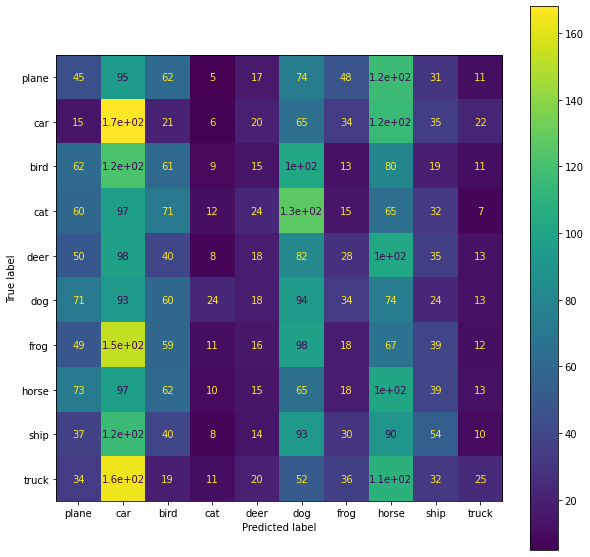

In [0]:
evaluate(model, dataloaders['val'])

## Saving the model in your drive

In [0]:
from google.colab import drive
drive.mount('content/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content/


In [0]:
model_save_name = "first_model.pt" #@param {type:"string"}
drive_path = "DNN/" #@param {type:"string"}
path = F"/content/content/My Drive/{drive_path}{model_save_name}" 
print(path)
torch.save(model.state_dict(), path)

#Note: make sure there is a folder called DNN (or whatever you want to call your saved models' folder) in the drive's path otherwise an error such as "there's no such directory or file" can rise.

## Loading the saved model

In [0]:
model = MLP() #@markdown Instantiate a mlp object

In [0]:
model_save_name = 'first_model.pt' #@param {type:"string"}
drive_path = "DNN/" #@param {type:"string"}
path = F"/content/content/My Drive/{drive_path}{model_save_name}" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Evaluate the loaded model

In [0]:
model.to(device)
evaluate(model, dataloaders['test'])
